In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery

В примере построения регрессионной модели мы используем набор данных `london_bicycles`. Предположим, что у нас есть два типа велосипедов: тяжелые и надежные городские велосипеды и быстрые, но менее надежные шоссейные велосипеды. Для клиентов, совершающих длительные поездки, у нас должны быть в наличии шоссейные велосипеды, а для коротких поездок — обычные городские. Чтобы организовать правильное распределение велосипедов, необходимо спрогнозировать продолжительность поездок.

In [ ]:
from google.colab import files

uploaded = files.upload()

PROJECT = 'positive-epoch-309122'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'positive-epoch-309122-c99ddc2242fc.json'

%load_ext google.cloud.bigquery

Saving positive-epoch-309122-c99ddc2242fc.json to positive-epoch-309122-c99ddc2242fc.json


### Выбор метки
Первым шагом к решению задачи машинного обучения является ее формулирование — определение признаков и меток для модели. Поскольку задача первой модели состоит в том, чтобы на основе набора архивных данных предсказать продолжительность поездки, меткой будет служить продолжительность поездки.

Но насколько верно мы определили цель задачи? Должна ли модель прогнозировать продолжительность каждой поездки или общую продолжительность всех поездок для каждого пункта проката, например, в течение часа? Если мы выберем последний вариант, тогда меткой должна быть сумма продолжительностей всех поездок за определенный час. Допустим, по опыту ведения бизнеса мы знаем, что пункт проката, выдающий 1000 велосипедов на 20 минут каждый, должен выдавать городские велосипеды, тогда как пункт проката, выдающий ежедневно 100 велосипедов на 200 минут, должен выдавать шоссейные велосипеды. То есть прогнозирование общей продолжительности не поможет принять правильное решение, а вот предсказание продолжительности каждой отдельной поездки будет весьма кстати.

Другой вариант — оценка вероятности, что поездка продлится меньше 30 минут. В этом случае метка будет иметь два значения — True/False — в зависимости от длительности поездки (больше или меньше 30 минут). Это еще больше поможет бизнесу, потому что вероятность может определять относительную пропорцию городских и шоссейных велосипедов, имеющихся в каждом пункте проката.

На практике довольно часто приходится выбирать между несколькими целями. Иногда можно создать метку в виде взвешенной комбинации из целей и обучить единственную модель. Иногда полезнее обучить несколько моделей, по одной для каждой цели, и использовать разные модели в разных сценариях. А иногда лучше представить конечному пользователю результаты всех моделей и дать ему возможность выбора. Все зависит от того, чем вы занимаетесь.

В этом примере мы построим две модели: одну для прогнозирования продолжительности поездки, а другую для прогнозирования вероятности того, что поездка займет больше 30 минут. Затем мы дадим конечному пользователю возможность принять решение на основе двух прогнозов.

### Выбор признаков в наборе данных
Если предположить, что продолжительность поездок зависит от пункта проката, дня недели и времени суток, эти параметры могут послужить нам входными признаками. Прежде чем продолжить и создать модель с этими тремя признаками, желательно убедиться, что эти факторы действительно влияют на метку.

Выбор и формирование признаков для модели машинного обучения называется конструированием признаков (feature engineering). Конструирование признаков часто является наиболее важным условием создания точных моделей машинного обучения, и этот шаг может гораздо сильнее повлиять на точность прогнозирования, чем выбор алгоритма или настройка гиперпараметров. Чтобы получить хороший набор признаков, необходимо глубоко понимать данные и предметную область. Часто на этом этапе проверяется множество гипотез; у вас есть идея относительно признака, вы проверяете ее обоснованность (влияние признака на метку), а затем добавляете этот признак в модель. Если эта идея не подтверждается, вы проверяете следующую.

#### Влияние пункта проката
Чтобы проверить зависимость продолжительности поездок от пункта проката, можно визуализировать результат следующего запроса, использовав `start_station_name` в качестве области определения и `duration` в качестве конкретных значений:

In [ ]:
%%bigquery duration --use_bqstorage_api --project $PROJECT
SELECT
  start_station_name
  , AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY start_station_name

Downloading: 100%|██████████| 880/880 [00:01<00:00, 766.22rows/s]


In [ ]:
duration.head()

,start_station_name,duration
0,"Serpentine Car Park, Hyde Park",1920.295582
1,"Speakers' Corner 1, Hyde Park",3710.466127
2,"Queen Street 2, Bank",979.783577
3,"Teviot Street, Poplar",1953.467181
4,"Wandsworth Rd, Isley Court, Wandsworth Road",1503.623323


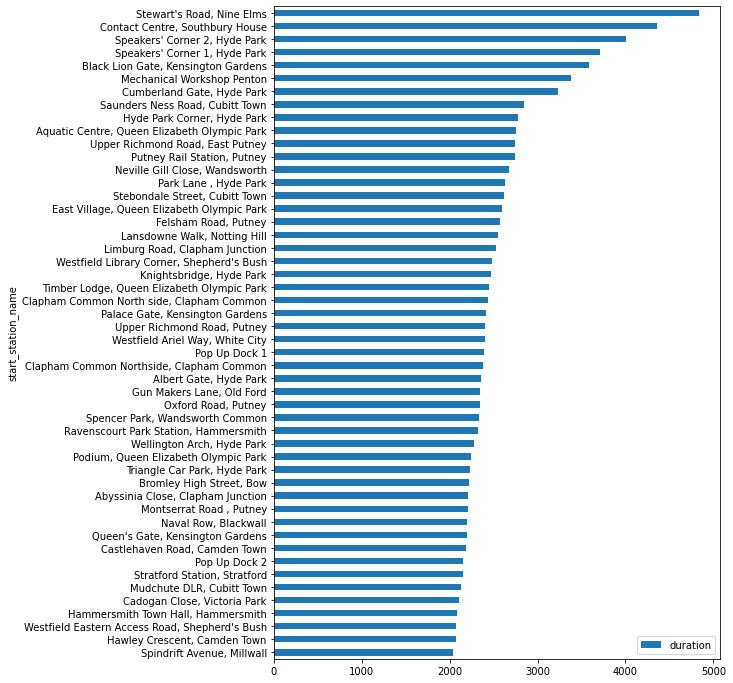

In [ ]:
duration.sort_values('duration', ascending=False) \
        .set_index('start_station_name')[:50] \
        .plot.barh(figsize=(8,12)).invert_yaxis();

На основании результатов, показанных выше на графике, можно сделать вывод, что длительные поездки (дольше 3000 секунд) в основном совершаются лишь из нескольких пунктов проката, и для большинства пунктов проката длительности поездок находятся в относительно узком диапазоне. Если бы они находились в узком диапазоне для всех пунктов проката в Лондоне, тогда пункт проката, где выдан велосипед, был бы плохим прогнозным признаком. Но в нашем случае признак `start_station_name` имеет значение.

Обратите внимание, что `end_station_name` не может использоваться в роли признака, потому что он неизвестен, пока велосипед не вернется на начальный пункт проката. Поскольку мы создаем модель машинного обучения для прогнозирования событий в будущем, не следует использовать столбцы, которые неизвестны на момент составления прогноза. Этот критерий причинноследственной связи накладывает ограничения на выбор признаков.

#### День недели
Оценка следующего кандидата в признаки выполняется аналогично: проверим значимость `dayofweek` — дня недели (точно так же можно проверить значимость `hourofday` — часа дня):

In [ ]:
%%bigquery dow --use_bqstorage_api --project $PROJECT
SELECT
  EXTRACT(dayofweek FROM start_date) AS dayofweek
  , AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY dayofweek

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.58rows/s]


In [ ]:
dow.head()

,dayofweek,duration
0,5,1190.617767
1,1,1866.445302
2,6,1253.651453
3,7,1754.172989
4,2,1188.622889


In [ ]:
%%bigquery hod --use_bqstorage_api --project $PROJECT
SELECT
  EXTRACT(hour FROM start_date) AS hourofday
  , AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY hourofday

Downloading: 100%|██████████| 24/24 [00:01<00:00, 15.75rows/s]


In [ ]:
hod.head()

,hourofday,duration
0,11,1560.743994
1,9,1045.294114
2,17,1253.381830
3,3,2388.941185
4,6,939.913277


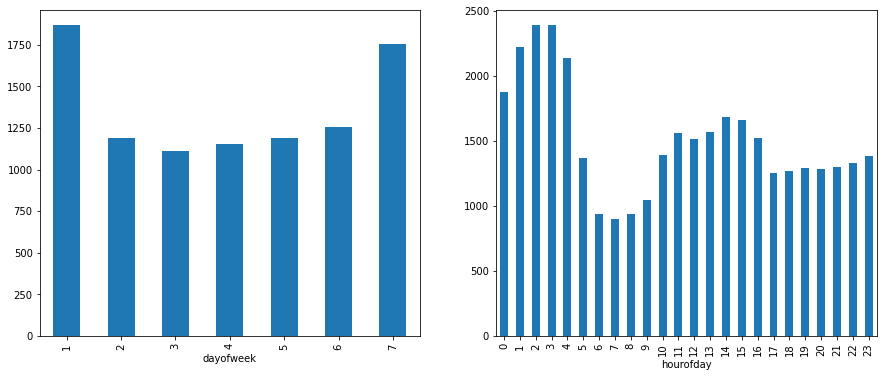

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
dow.groupby('dayofweek')['duration'].mean().plot.bar(ax=ax[0])
hod.groupby('hourofday')['duration'].mean().plot.bar(ax=ax[1]);

Как показано диаграммах, продолжительность поездок зависит от дня недели и от времени суток. Поездки, совершаемые в выходные дни (дни 1 и 7), длятся дольше, чем в будние дни. Аналогично дольше длятся поездки, совершаемые рано утром и в первой половине дня. То есть обе переменные — `dayofweek` и `hourofday` — являются хорошими признаками.

### Количество велосипедов
Еще один потенциальный признак — количество велосипедов на пункте проката. Можно предположить, что люди совершают более длительные поездки, если на пункте проката, куда они обратились, доступно небольшое число велосипедов. Проверить это можно с помощью следующего запроса:

In [ ]:
%%bigquery bikes_count --use_bqstorage_api --project $PROJECT
SELECT
  bikes_count
  , AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
JOIN `bigquery-public-data`.london_bicycles.cycle_stations
ON cycle_hire.start_station_name = cycle_stations.name
GROUP BY bikes_count

Downloading: 100%|██████████| 45/45 [00:01<00:00, 34.76rows/s]


In [ ]:
bikes_count.head()

,bikes_count,duration
0,3,1396.412638
1,33,1374.301577
2,29,1262.889660
3,19,1360.931928
4,36,1706.174838


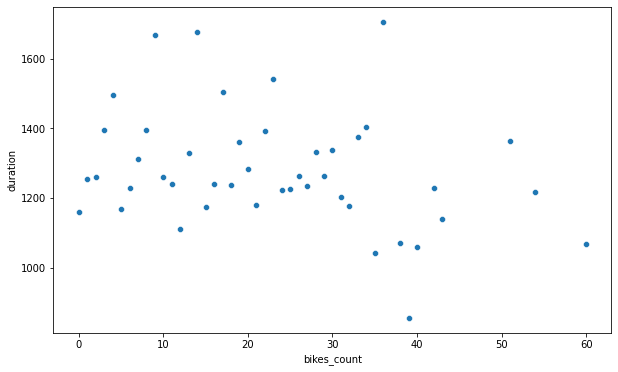

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=bikes_count, x='bikes_count', y='duration');

Как видим, между продолжительностью поездки и количеством велосипедов на пункте проката нет очевидной связи (в отличие от времени суток). Это подсказывает нам, что количество велосипедов не является хорошим признаком. Подтвердим это количественно, вычислив коэффициент корреляции Пирсона:

In [ ]:
client = bigquery.Client()         

query = """
SELECT
  CORR(bikes_count, duration) AS corr
FROM `bigquery-public-data`.london_bicycles.cycle_hire
JOIN `bigquery-public-data`.london_bicycles.cycle_stations
ON cycle_hire.start_station_name = cycle_stations.name
"""

query_job = client.query(query)
query_job.result().to_dataframe()

,corr
0,0.004163


Результат показывает, что переменные `bikes_count` и `duration` практически независимы, потому что значение 0.0 коэффициента Пирсона соответствует полному отсутствию, а абсолютное значение 1.0 — абсолютной линейной зависимости.

Коэффициент корреляции Пирсона не является идеальным показателем полезности того или иного признака, потому что учитывает только линейную зависимость. Иногда признаки могут иметь нелинейную зависимость от метки. Но в любом случае коэффициент Пирсона является хорошей первичной оценкой. Специалисты в области машинного обучения часто используют более сложные статистические проверки, такие как взаимная информация, которая вычисляет случайность изменения признака с изменением метки.

### Создание обучающего набора данных

На основании результатов исследований набора данных `london_bicycles` и выявленных взаимосвязей между различными столбцами со столбцом меток можно подготовить обучающий набор данных, включающий выбранные признаки и метки:

In [ ]:
%%bigquery df --use_bqstorage_api --project $PROJECT
SELECT
  duration
  , start_station_name
  , CAST(EXTRACT(dayofweek FROM start_date) AS STRING) as dayofweek
  , CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
FROM `bigquery-public-data`.london_bicycles.cycle_hire

Столбцы признаков должны быть числовыми (INT64, FLOAT64 и т. д.) или категориальными (STRING). Если признак выражается числом, но должен рассматриваться как категориальный, его следует привести к типу STRING — это объясняет преобразование в строки столбцов `dayofweek` и `hourofday` в этом запросе, которые хранят целые числа (в диапазонах от 1 до 7 и от 0 до 23 соответственно).

>Можно рассматривать эти переменные как значения из непрерывного диапазона, но тогда мы столкнулись бы с необходимостью бороться с тем фактом, что dayofweek = 7 ближе к dayofweek = 1, чем к dayofweek = 5. Для справки, нам понадобилось бы: (a) сохранить dayofweek дважды, один раз в текущей форме, а другой как `MOD (dayofweek + 3, 7)` и (б) заменить dayofweek на `sin(2π * dayofweek / 7.0)`. Эти сложности трудно объяснить заинтересованным сторонам. Если это не проблема и вы решаете похожую задачу, поэкспериментируйте со всеми тремя представлениями, чтобы определить, какое из них позволяет получить более точные результаты.

### Обучение и оценка модели

Чтобы обучить модель и сохранить ее в наборе данных data, нужно вызвать инструкцию `CREATE MODEL`, которая работает аналогично `CREATE TABLE`:
```sql
CREATE OR REPLACE MODEL data.bicycle_model
OPTIONS(input_label_cols=['duration'], model_type='linear_reg') AS
SELECT
  duration
  , start_station_name
  , CAST(EXTRACT(dayofweek FROM start_date) AS STRING) as dayofweek
  , CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
FROM `bigquery-public-data`.london_bicycles.cycle_hire
```
Обратите внимание, что столбец меток и тип модели определяются в `OPTIONS`. Поскольку метка является числом, эта задача относится к разряду задач регрессии. Вот почему мы выбрали тип модели `linear_reg`. Оператор SELECT в запросе выше подготавливает обучающий набор данных и извлекает столбцы меток и элементов.

#### Оценка модели
Этот запрос был выполнен за 2.5 минуты и произвел единственную итерацию обучения. Средняя абсолютная ошибка (доступная на вкладке оценки) составляет 1026 секунд, или около 17 минут. То есть модель способна прогнозировать продолжительность поездок со средней ошибкой около 17 минут.

Результаты оценки также можно получить, выполнив следующий SQL-запрос:

```sql
SELECT * FROM ML.EVALUATE(MODEL data.bicycle_model)
```

Рекомендуется выбирать простые модели и больше времени тратить на обдумывание и выбор комбинаций признаков, потому что отдача от нового/улучшенного набора входных признаков значительно превышает отдачу от использования более совершенной модели. Только достигнув максимальных показателей в ходе экспериментов с признаками, можно попробовать более сложные модели.

### Комбинирование дней недели
Выше мы уже говорили, что есть несколько способов представления признаков. Например, исследуя взаимосвязь между днем недели и продолжительностью поездки, мы обнаружили, что в выходные дни поездки длятся дольше, чем в будни. Зная это, в роли признака вместо исходного значения `dayofweek` можно использовать категории, объединяющие несколько значений `dayofweek`:

```sql
CREATE OR REPLACE MODEL data.bicycle_model_weekday
OPTIONS(input_label_cols=['duration'], model_type='linear_reg') AS
SELECT
  duration
  , start_station_name
  , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6,
        'weekday', 'weekend') as dayofweek
  , CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
FROM `bigquery-public-data`.london_bicycles.cycle_hire
```

Эта модель имеет среднюю абсолютную ошибку 967 секунд, то есть меньше 1026 секунд в предыдущей модели. Это повод перейти к модели weekend/weekday.

### Группировка по времени суток
Опять же, исходя из установленной зависимости между временем суток и про- должительностью поездок, можно поэкспериментировать с делением времени на четыре периода: (–inf, 5), [5,10), [10,17) и [17, inf):

```sql
CREATE OR REPLACE MODEL data.bicycle_model_bucketized
OPTIONS(input_label_cols=['duration'], model_type='linear_reg') AS
SELECT
  duration
  , start_station_name
  , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6, 'weekday', 'weekend') as dayofweek
  , ML.BUCKETIZE(EXTRACT(hour FROM start_date), [5, 10, 17]) AS hourofday
FROM `bigquery-public-data`.london_bicycles.cycle_hire
```

`ML.BUCKETIZE` может служить примером функций предварительной обработки, поддерживаемых в BigQuery, — мы передаем ей число для группировки и устанавливаем границы групп, где предполагается, что первая группа ограничена слева значением –∞, а последняя ограничена справа значением +∞. Эта модель дает среднюю абсолютную ошибку в 901 секунду, что меньше, чем 967 секунд в модели weekend/weekday. Поэтому используем модель с группировкой по времени суток.

### Получение прогнозов с помощью модели
Обученную модель можно использовать для прогнозирования, передавая ей наборы записей. Например, вот как можно получить прогнозируемую продолжительность поездок от пункта проката в Гайд-парке в 17:00 во вторник.

#### Необходимость преобразований с помощью TRANSFORM
В предыдущем запросе мы должны были передать в поле `dayofweek` значение 'weekday', а не '3', потому что при обучении модель получала в `dayofweek` значения 'weekday' и 'weekend'. Также не следовало передавать непосредственное значение '17' в поле `hourofday` — мы должны передать имя группы, представляющей 17 часов. Проще говоря, чтобы получить правильные значения, в запросе прогноза необходимо выполнить те же преобразования, что и в обучающем коде.
Было бы неплохо, если бы BigQuery могла запоминать, какие преобразования применялись на этапе обучения, и автоматически применяла их на этапе предсказания. Самое замечательное, что это возможно, — именно это делает предложение `TRANSFORM`!
Более того, извлечение времени суток и дня недели можно перенести в предложение `TRANSFORM`, чтобы клиентский код передавал только отметку времени, соответствующую началу поездки:

```sql
CREATE OR REPLACE MODEL data.bicycle_model_bucketized
TRANSFORM(* EXCEPT(start_date)
         , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6, 'weekday', 'weekend') as dayofweek
         , ML.BUCKETIZE(EXTRACT(HOUR FROM start_date), [5, 10, 17]) AS hourofday
)
OPTIONS(input_label_cols=['duration'], model_type='linear_reg') AS
SELECT
  duration
  , start_station_name
  , start_date
FROM `bigquery-public-data`.london_bicycles.cycle_hire
```

Используйте предложение `TRANSFORM` и сформулируйте задачу машинного обучения так, чтобы любому, кому потребуется прогноз, достаточно было передать только исходные данные.

Если в запросе есть предложение `TRANSFORM`, модель обучается на его выходных данных. В таком случае предложению `TRANSFORM` передаются все признаки и метки, возвращаемые исходным запросом `SELECT`, кроме `start_date`, а затем добавляется пара признаков (`dayofweek` и `hourofday`), извлеченных из `start_date`.

Для прогнозирования продолжительности поездки получившаяся модель требует передать ей только `start_station_name` и `start_date`. Преобразования сохраняются и применяются к переданным данным для получения входных признаков.

После добавления предложения `TRANSFORM` запрос на получение прогноза приобретает следующий вид:

```sql
SELECT * FROM ML.PREDICT(MODEL data.bicycle_model_bucketized,
  (SELECT
    'Park Lane , Hyde Park' AS start_station_name
    , CURRENT_TIMESTAMP() AS start_date)
)
```

### Получение пакетных прогнозов
Также есть возможность создать таблицу прогнозов для каждого часа и каждого пункта проката начиная с 3 часов утра следующего дня, если использовать функцию генерирования массива:

```sql
DECLARE tomorrow_3am TIMESTAMP;
SET tomorrow_3am = TIMESTAMP_ADD(
  TIMESTAMP(DATE_ADD(CURRENT_DATE(), INTERVAL 1 DAY)),
  INTERVAL 3 HOUR);
WITH generated AS (
  SELECT
    name AS start_station_name
    , GENERATE_TIMESTAMP_ARRAY(
      tomorrow_3am,
      TIMESTAMP_ADD(tomorrow_3am, INTERVAL 24 HOUR),
      INTERVAL 1 HOUR) AS dates
  FROM
    `bigquery-public-data`.london_bicycles.cycle_stations
),
features AS (
  SELECT
    start_station_name
    , start_date
FROM
    generated
    , UNNEST(dates) AS start_date
)
SELECT * FROM ML.PREDICT(MODEL data.bicycle_model_bucketized,
  (SELECT * FROM features)
)
```
Этот запрос вернет около 20 000 прогнозов.

Использование человеческих знаний и вспомогательных данных
Помимо использования моделей с разными архитектурами и настройки их параметров, можно подумать о добавлении новых входных признаков, включая вспомогательные данные и человеческие знания.

Например, в предыдущей модели мы использовали функцию `ML.BUCKETIZE`, чтобы разбить непрерывную переменную (час, извлеченный из отметки времени) на четыре диапазона. Еще одна чрезвычайно полезная функция — `ML.FEATURE_CROSS` — позволяет объединить отдельные категориальные признаки в условие по AND (подобные взаимозависимости между признаками с трудом определяются моделями машинного обучения). Как подсказывает интуиция, сочетание дня недели и утренних часов в нашей задаче является хорошим прогнозирующим признаком продолжительности поездок на велосипедах, гораздо более значимым, чем день недели или утренние часы сами по себе. Возможно, есть смысл определить пересечение этих двух признаков вместо того, чтобы рассматривать день недели и время по отдельности:

```sql
ML.FEATURE_CROSS(STRUCT(
  IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6,
        'weekday', 'weekend') as dayofweek,
  ML.BUCKETIZE(EXTRACT(HOUR FROM start_date),
        [5, 10, 17]) AS hr
)) AS dayhr
```

До сих пор в качестве входных данных для моделей мы использовали `start_station_name`. При этом пункты проката считаются независимыми друг от друга. А что, если добавить в модель вспомогательный признак с информацией о местонахождении пунктов проката?
Следующий обучающий запрос объединяет эти две идеи:

```sql
CREATE OR REPLACE MODEL data.bicycle_model_fc_geo
 TRANSFORM(duration
      , ML.FEATURE_CROSS(STRUCT(
          IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6,
             'weekday', 'weekend') as dayofweek,
          ML.BUCKETIZE(EXTRACT(HOUR FROM start_date),
             [5, 10, 17]) AS hr
        )) AS dayhr
      , ST_GeoHash(ST_GeogPoint(latitude, longitude), 4) AS start_station_loc4
      , ST_GeoHash(ST_GeogPoint(latitude, longitude), 6) AS start_station_loc6
      , ST_GeoHash(ST_GeogPoint(latitude, longitude), 8) AS start_station_loc8
)
OPTIONS(input_label_cols=['duration'], model_type='linear_reg')
AS
SELECT
  duration
  , latitude
  , longitude
  , start_date
FROM `bigquery-public-data`.london_bicycles.cycle_hire
JOIN `bigquery-public-data`.london_bicycles.cycle_stations
ON cycle_hire.start_station_id = cycle_stations.id
```

Эта модель имеет среднюю абсолютную ошибку, равную 898 секундам, то есть показывает более высокую точность по сравнению с 901 секундой, которую мы наблюдали выше. Однако улучшение получилось весьма незначительным.


In [ ]:
#pd.cut(df['start_date'].dt.hour, bins=[-np.inf, 5, 10, 17, np.inf],
#                                 labels=['bin_1', 'bin_2', 'bin_3', 'bin_4'],
#                                 right=False)

In [ ]:
df.head()

,duration,start_station_name,start_date,dayofweek,hourofday
0,7200,"One Tower Bridge, Bermondsey",2017-05-28 10:18:00+00:00,weekend,bin_3
1,2940,"Borough High Street, The Borough",2015-12-31 13:40:00+00:00,weekday,bin_3
2,2460,"Warwick Avenue Station, Maida Vale",2015-08-01 15:01:00+00:00,weekend,bin_3
3,2940,"Neville Gill Close, Wandsworth",2016-08-29 14:30:00+00:00,weekday,bin_3
4,2160,"Clarence Walk, Stockwell",2016-03-12 16:00:00+00:00,weekend,bin_3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24369201 entries, 0 to 24369200
Data columns (total 4 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   duration            int64 
 1   start_station_name  object
 2   dayofweek           object
 3   hourofday           object
dtypes: int64(1), object(3)
memory usage: 743.7+ MB


In [ ]:
df.head()

,duration,start_station_name,dayofweek,hourofday
0,4560,"Hereford Road, Bayswater",weekend,bin_4
1,8700,"Speakers' Corner 2, Hyde Park",weekend,bin_2
2,2220,"Royal Avenue 2, Chelsea",weekend,bin_3
3,6360,"Trebovir Road, Earl's Court",weekday,bin_1
4,5220,"Walworth Road, Elephant & Castle",weekday,bin_4


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [ ]:
y = df.pop('duration').values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=42)

In [ ]:
ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')
X_train_transformed = ohe.fit_transform(X_train)

In [ ]:
ohe.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_Abbey Orchard Street, Westminster',
       'x0_Abbotsbury Road, Holland Park',
       "x0_Aberdeen Place, St. John's Wood",
       'x0_Aberfeldy Street, Poplar',
       'x0_Abingdon Green, Great College Street',
       'x0_Abingdon Green, Westminster', 'x0_Abingdon Villas, Kensington',
       'x0_Abyssinia Close, Clapham Junction', 'x0_Ackroyd Drive, Bow',
       'x0_Ada Street, Hackney Central', 'x0_Addison Road, Holland Park',
       'x0_Aintree Street, Fulham', "x0_Albany Street, Regent's Park",
       "x0_Albany Street, The Regent's Park",
       'x0_Albert Bridge Road, Battersea Park',
       'x0_Albert Embankment, Vauxhall', 'x0_Albert Gardens, Stepney',
       'x0_Albert Gate, Hyde Park', 'x0_Albert Square, Stockwell',
       'x0_Alderney Street, Pimlico', 'x0_Aldersgate Street, Barbican',
       'x0_Alfred Place, Bloomsbury', 'x0_Alfreda Street, Battersea Park',
       'x0_All Saints Church, Portobello',
       "x0_All Saints' Road, Portobello", 'x0_Alma Road, Wandsw

In [ ]:
X_test_transformed = ohe.transform(X_test)

In [ ]:
lm = LinearRegression().fit(X_train_transformed, y_train)

In [ ]:
lm.intercept_

1545.7107585224649

In [ ]:
preds = lm.predict(X_test_transformed)

In [ ]:
from sklearn.metrics import mean_absolute_error

Для большинства задач регрессии абсолютная средняя ошибка MAE обеспечивает хороший баланс между нечувствительностью к выбросам и чувствительностью к итеративным улучшениям. Используйте абсолютную среднюю ошибку, если нет веских причин не делать этого.

In [ ]:
mean_absolute_error(y_test, preds)

967.1921592606759

In [ ]:
lm.score(X_test_transformed, y_test)

0.002976858872595356

In [ ]:
to_pred = pd.DataFrame(
    {'start_station_name': 'Park Lane , Hyde Park',
    'start_date': pd.to_datetime('2019-05-19 04:24:03.376064 UTC')},
    index=[0]
)

In [ ]:
lm.predict(ohe.transform(to_pred[['start_station_name',	'dayofweek',	'hourofday']]))

array([3130.67772761])

In [ ]:
to_pred = to_pred.assign(dayofweek=np.where(to_pred['start_date'].dt.dayofweek.between(2,6), 'weekday', 'weekend')) \
                 .assign(hourofday=np.select([to_pred['start_date'].dt.hour < 5, 
                                              to_pred['start_date'].dt.hour < 10,
                                              to_pred['start_date'].dt.hour < 17],
                                             ['bin_1', 'bin_2', 'bin_3'], 'bin_4'))

## Создание модели классификации
Мы построили модели машинного обучения, прогнозирующие продолжительность поездок. Однако в течение одного часа в прокат будет сдаваться большое число велосипедов и их сроки аренды будут разными. Рассмотрим распределение продолжительностей поездок на велосипедах, взятых в прокат на пункте Роял-авеню 1 в Челси по будням в 14:00:

In [ ]:
%%bigquery t --use_bqstorage_api --project $PROJECT
SELECT
  APPROX_QUANTILES(duration, 10) AS q
FROM `bigquery-public-data`.london_bicycles.cycle_hire
WHERE
  EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6
  AND EXTRACT(hour FROM start_date) = 14
  AND start_station_name = 'Royal Avenue 1, Chelsea'

In [ ]:
t.explode('q', ignore_index=True)

,q
0,0
1,240
2,420
3,540
4,660
5,840
6,1020
7,1260
8,1500
9,2040


Восемьдесят процентов поездок, совершенных в будни от этого пункта проката, длилось меньше 1500 секунд. Если бы вы ограничились только этим прогнозом, то могли бы решить разместить на этом пункте проката в такие дни только городские велосипеды. Однако зная, что примерно от 10 до 20% поездок длится больше 1800 секунд, вы могли дополнительно разместить 15% шоссейных велосипедов. Спрогнозировать вероятность продолжительности поездки дольше 1800 секунд вам поможет модель классификации.

### Обучение
Для простоты возьмем тот же набор признаков, который мы использовали в регрессионной модели, и обучим модель прогнозировать вероятность того, что поездка продлится больше 30 минут:

```sql
CREATE OR REPLACE MODEL data.bicycle_model_longrental
TRANSFORM(* EXCEPT(start_date)
          , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6,
'weekday', 'weekend') as dayofweek
          , ML.BUCKETIZE(EXTRACT(HOUR FROM start_date), [5, 10, 17]) AS
hourofday
)
OPTIONS(input_label_cols=['biketype'], model_type='logistic_reg') AS
SELECT
  IF(duration > 1800, 'roadbike', 'commuter') AS biketype
  , start_station_name
  , start_date
FROM `bigquery-public-data`.london_bicycles.cycle_hire
```

Обратите внимание, что на этот раз выбран тип модели `logistic_reg` (логистическая регрессия) — это самый простой тип моделей для задач классификации. Для классификации с использованием глубокой нейронной сети или дерева решений с градиентным бустингом используйте `dnn_classifier` или `boosted_tree_classifier` соответственно.

Мы создали метки, определив порог продолжительности поездок, равный 1800 секундам, и дали двум категориям имена `roadbike` (шоссейный велосипед) и `commuter` (городской велосипед). Примерно так же мы определили категории weekend/weekday на основе числовой переменной `dayofweek`. Мы могли бы применить логическое значение (True/False), но использование фактических имен категорий делает наши намерения более понятными.

В конце обучения вы увидите, что за семь итераций обучения ошибка уменьшилась и достигла минимального уровня.

### Прогнозирование
Прогнозирование с использованием этой модели производится точно так же, как в случае с моделью линейной регрессии, только на этот раз возвращается вероятность каждого класса:

```sql
SELECT * FROM ML.PREDICT(MODEL data.bicycle_model_longrental,
  (SELECT 'Park Lane , Hyde Park' AS start_station_name
)
, TIMESTAMP('2019-05-09 16:16:00 UTC') AS start_date)
```

### Выбор порога
В нашем случае интерес представляет прогнозируемая вероятность. Однако во многих задачах классификации предпочтительнее получить не только вероятность, но и прогнозируемый класс. То есть результат прогноза (см. предыдущий раздел) должен включать не только вероятность, но также класс с наибольшей вероятностью. В задаче бинарной классификации это равносильно установке порогового значения вероятности, равного 0.5, и выбору класса с вероятностью больше этого порога.

Полнотой (recall) в машинном обучении называют процент фактических истинных результатов (отношение истинно-положительных результатов к общему числу положительных результатов) в определенной пороговой точке. Хороший порог должен иметь высокую полноту. Однако выбор пороговой точки с высоким значением полноты таит опасность получения большого количества ложно-положительных результатов. Если выбрать порог, равный нулю, вы получите весь набор данных и, соответственно, идеальную полноту.

Другим важным показателем является точность (precision) — процент истинно- положительных результатов по всему набору данных. Это можно выразить так: «Я спрогнозировал, что этот результат истинный, но какова вероятность, что я прав?» Если установить порог равным нулю, истинными будут далеко не все полученные результаты. (То есть если вы спрогнозировали, что все результаты верны, но в действительности верными будут только 10%, точность составит 10%. Это плохой результат для классификатора.)

Совокупные показатели на вкладке Evaluation (Оценка), например accuracy=0.89, рассчитываются на основе порога 0.5.
Если вы хотите, чтобы в 50% случаев, когда требуется шоссейный велосипед, он был в наличии, тогда вам нужна полнота 0.5, потому что достаточно охватить половину продолжительных поездок. Если хотите, можете воспользоваться пол- зунком на вкладке Evaluation (Оценка) и установить пороговое значение равным 0.144, как показано на рис. 9.8, чтобы получить желаемую величину метрики полноты. Обратите внимание, что это происходит за счет точности; при этом пороговом значении модель обеспечит точность на уровне 0.26 — только в 26% случаев спрогнозированные поездки будут длиться дольше 30 минут и для них потребуется выдать шоссейный велосипед.

При использовании моделей бинарной классификации желаемый порог можно
передать в `ML.PREDICT`:

```sql
SELECT * FROM ML.PREDICT(MODEL data.bicycle_model_longrental,
  (SELECT 'Park Lane , Hyde Park' AS start_station_name
          , TIMESTAMP('2019-05-09 16:16:00 UTC') AS start_date),
  STRUCT(0.144 AS threshold)
)
```


In [ ]:
%%bigquery df --use_bqstorage_api --project $PROJECT
SELECT
  start_station_name
  --, start_date
  , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6, 'weekday', 'weekend') as dayofweek
  , ML.BUCKETIZE(EXTRACT(hour FROM start_date), [5, 10, 17]) AS hourofday
  , IF(duration > 1800, 'roadbike', 'commuter') AS biketype
FROM `bigquery-public-data`.london_bicycles.cycle_hire

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
y = df.pop('biketype')
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=0, stratify=y)

In [ ]:
# categorical columns
cat_ohe_step = ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
cat_pipe = Pipeline([cat_ohe_step])
cat_cols = ['start_station_name', 'dayofweek',	'hourofday']
cat_transformers = ('cat', cat_pipe, cat_cols)
# numeric columns
#num_ss_step = ('ss', StandardScaler())
#num_pipe = Pipeline([num_ss_step])
#num_transformers = ('num', num_pipe, ['duration']) # one numeric col
transformers = [cat_transformers]
ct = ColumnTransformer(transformers=transformers)

In [ ]:
lr_pipe = Pipeline(
    [
        ('transform', ct),
        ('lr', LogisticRegression(class_weight='balanced', random_state=0))
    ]
)

In [ ]:
lr_pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['start_station_name',
                                                   'dayofweek',
                                                   'hourofday'])])),
                ('lr',
                 LogisticRegression(class_weight='balanced', random_state=0))])

In [ ]:
lr_pipe.score(X_test, y_test)

0.6973233847137433

In [ ]:
from sklearn.metrics import classification_report, f1_score

In [ ]:
y_pred = lr_pipe.predict(X_test)
report = classification_report(y_pred, y_test)

In [ ]:
print(report)

              precision    recall  f1-score   support

    commuter       0.70      0.94      0.81   1617682
    roadbike       0.65      0.21      0.32    819239

    accuracy                           0.70   2436921
   macro avg       0.68      0.58      0.56   2436921
weighted avg       0.69      0.70      0.64   2436921



In [ ]:
to_pred = pd.DataFrame(
    {'start_station_name': 'Park Lane , Hyde Park',
     'start_date': pd.to_datetime('2019-05-09 16:16:00 UTC')},
    index=[0]
)

In [ ]:
to_pred = to_pred.assign(dayofweek=np.where(to_pred['start_date'] \
                            .dt.dayofweek.between(2,6), 'weekday', 'weekend')) \
                 .assign(hourofday=np.select(
                     [to_pred['start_date'].dt.hour < 5, 
                      to_pred['start_date'].dt.hour < 10,
                      to_pred['start_date'].dt.hour < 17],
                     ['bin_1', 'bin_2', 'bin_3'], 'bin_4')) \
                 .drop(columns='start_date')

In [ ]:
lr_pipe.predict_proba(to_pred)

array([[0.15273637, 0.84726363]])

In [ ]:
probabilities_valid = lr_pipe.predict_proba(X_test)

In [ ]:
predicted_test = np.where(probabilities_valid[:,1] > 0.144, 'roadbike', 'commuter')
round(f1_score(y_test, predicted_test, pos_label='roadbike'), 4)

0.2018

### Управление делением данных
По умолчанию для наборов данных среднего размера BigQuery случайным образом отбирает 20% данных и сохраняет их для оценки. Обучение проводится только на 80% предоставленных данных. Для небольших наборов данных (с числом записей меньше 500) для обучения используются все данные, а для больших наборов данных (с числом записей больше 50 000) для оценки используется только 10 000 записей. Управлять выбором данных для оценки можно с помощью трех параметров: `data_split_method`, `data_split_eval_fraction` и `data_split_col`.

```sql
CREATE OR REPLACE MODEL data.bicycle_model_bucketized_seq
TRANSFORM(* EXCEPT(start_date)
           , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6, 'weekday', 'weekend') AS dayofweek
           , ML.BUCKETIZE(EXTRACT(HOUR FROM start_date), [5, 10, 17])
                                                         AS hourofday
           , start_date -- used to split the data
)
OPTIONS(input_label_cols=['duration'], model_type='linear_reg',
        data_split_method='seq',
        data_split_eval_fraction=0.2,
        data_split_col='start_date')
AS
SELECT
  duration
  , start_station_name
  , start_date
FROM `bigquery-public-data`.london_bicycles.cycle_hire
```

Средняя абсолютная ошибка этой модели составляет 860 секунд, но мы не можем сравнить это число с результатом, полученным при случайном разделении данных, — оценочные показатели сильно зависят от выбора данных для оценки, и поскольку сейчас используется другой набор контрольных данных, мы не можем сравнить эти результаты с результатами, полученными ранее. Кроме того, предыдущие результаты были искажены утечкой информации, как описывалось на примере рождественских дней.

### Балансировка классов
В задаче классификации менее 12% поездок длится дольше 1800 секунд. Это пример несбалансированного набора данных. Возможно, будет полезно придать более редкому классу более высокий вес. Это можно сделать, явно передав массив весов классов или отправив запрос BigQuery установить веса классов, опираясь на обратную частоту.

```sql
CREATE OR REPLACE MODEL data.bicycle_model_longrental_balanced
TRANSFORM(* EXCEPT(start_date)
          , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6, 'weekday', 'weekend') as dayofweek
          , ML.BUCKETIZE(EXTRACT(HOUR FROM start_date), [5, 10, 17]) AS hourofday
          , start_date)
OPTIONS(input_label_cols=['biketype'],
        model_type='logistic_reg',
        data_split_method='seq',
        data_split_eval_fraction=0.2,
        data_split_col='start_date',
        auto_class_weights=True)
AS
SELECT
  IF(duration > 1800, 'roadbike', 'commuter') AS biketype
  , start_station_name
  , start_date
FROM `bigquery-public-data`.london_bicycles.cycle_hire
```

Обратите внимание, что после балансировки весов вероятность, возвращаемая моделью, больше не является оценкой фактической частоты событий. Это связано с тем, что оценка вероятности, полученная в результате логистической регрессии, основана на частоте появления событий в данных, наблюдаемых моделью, и мы искусственно увеличили частоту появления редких событий.

## Регуляризация
Как уже отмечалось выше, большинство пунктов проката имеют почти одинаковую продолжительность поездок, за исключением нескольких случаев с необычно продолжительными поездками. Многие из этих пунктов проката насчитывают очень мало поездок. Категориальные признаки, имеющие такое распределение с длинным хвостом, могут вызвать переобучение. Под переобучением понимается ситуация, при которой модель запоминает шум (случайные флуктуации) в данных, а не изучает сигнал. Другими словами, модель может стать настолько сложной, что будет представлять сам набор данных, а не его базовые качества.

Регуляризация помогает избежать переобучения, снижая сложность, в частности, за счет введения штрафа за большие значения весов. Большие значения весов часто являются признаком переобучения, потому что могут внезапно включаться, когда имеется ровно одна точка данных.

BigQuery ML поддерживает два типа регуляризации: L1 и L2. Регуляризация L1 подталкивает отдельные веса к нулю и лучше поддается интерпретации, а регуляризация L2 стремится сохранить все веса относительно одинаковыми и лучше справляется с предотвращением переобучения. Управлять величиной регуляризации L1 или L2 можно при создании модели:

```sql
CREATE OR REPLACE MODEL data.bicycle_model_bucketized_seq_l2
TRANSFORM(* EXCEPT(start_date)
          , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6,
                       'weekday', 'weekend') as dayofweek
          , ML.BUCKETIZE(EXTRACT(HOUR FROM start_date), [5, 10, 17]) AS
                         hourofday
          , start_date -- used to split the data
)
OPTIONS(input_label_cols=['duration'],
        model_type='linear_reg',
        data_split_method='seq',
        data_split_eval_fraction=0.2,
        data_split_col='start_date',
        l2_reg=0.1)
AS
SELECT
  duration
  , start_station_name
  , start_date
FROM `bigquery-public-data`.london_bicycles.cycle_hire
```

В этом случае средняя абсолютная ошибка получилась равной 857 секундам, то есть она почти идентична полученной без регуляризации L2. Причина, скорее всего, в том, что у нас есть достаточно большой набор данных и определено всего несколько настроек, чего оказалось достаточно, чтобы переобучения не произошло. Регуляризация L2 обычно считается наилучшим выбором, особенно для небольших наборов данных или при использовании достаточно сложной модели (например, глубокой нейронной сети) с большим числом параметров.

In [ ]:
%%bigquery df --use_bqstorage_api --project $PROJECT
SELECT
  start_station_name
  , start_date
  , duration
  , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6, 'weekday', 'weekend') AS dayofweek
  , ML.BUCKETIZE(EXTRACT(hour FROM start_date), [5, 10, 17]) AS hourofday
FROM `bigquery-public-data`.london_bicycles.cycle_hire

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
df.sort_values('start_date', inplace=True)

In [ ]:
y = df.pop('duration')
df.drop(columns='start_date', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    df, y,
    test_size=0.2,
    shuffle=False,
    random_state=0,
    stratify=None
)

In [ ]:
cat_ohe_step = ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
cat_pipe = Pipeline([cat_ohe_step])
cat_cols = ['start_station_name', 'dayofweek',	'hourofday']
cat_transformers = ('cat', cat_pipe, cat_cols)
transformers = [cat_transformers]
ct = ColumnTransformer(transformers=transformers)

In [ ]:
ridge_pipe = Pipeline(
    [
        ('transform', ct),
        ('ridge', Ridge(alpha=0.1, random_state=0))
    ]
)

In [ ]:
ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['start_station_name',
                                                   'dayofweek',
                                                   'hourofday'])])),
                ('ridge', Ridge(alpha=0.1, random_state=0))])

In [ ]:
y_pred = ridge_pipe.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(y_test, y_pred)

702.5896297724232

## Кластеризация методом k-средних
Рассматриваемые до настоящего времени алгоритмы машинного обучения относились к категории методов обучения с учителем — мы должны были предоставить столбец меток. Однако BigQuery поддерживает также методы обучения без учителя. Например, мы можем применить к данным алгоритм кластеризации методом k-средних (https://en.wikipedia.org/wiki/K-means_clustering) для группировки их в кластеры на основе сходства. Такое название алгоритм получил, потому что определяет k кластеров, каждый из которых описывается средним значением его членов. В отличие от машинного обучения с учителем, помогающим предсказать значение столбца метки для новых данных, которые модель еще не видела, обучение без учителя носит описательный характер. Используйте `model_type = kmeans` в BigQuery, чтобы получить описание данных с точки зрения центроидов k кластеров, выявленных в данных, и принять решение о принадлежности к тому или иному кластеру на основе атрибутов его центроида.

### Выбор признаков для кластеризации
Первым шагом в использовании алгоритма кластеризации методом k-средних является выбор признаков для кластеризации. Поскольку таблицы в BigQuery склонны к сглаживанию и описывают несколько аспектов, выбор способа помогает понять, какие общие характеристики имеют члены кластера.

Предположим, у вас есть данные, каждая запись в которых представляет розничную покупку. Кластеризовать такую таблицу можно несколькими способами, и выбор способа зависит от того, что предполагается делать с кластерами:
 - Можно попробовать выявить естественные группы среди клиентов. Этот прием называется сегментацией клиентов. Данные, используемые для сегментации клиентов, будут играть роль атрибутов, описывающих клиентов, совершающих покупки, — к ним можно отнести, например, магазин, где совершена покупка, наименование купленных товаров, стоимость покупки и т. д. Цель кластеризации по клиентам — желание понять, какие отличительные особенности имеют группы клиентов (они называются персонами), чтобы на их основе можно было создать элементы, представляющие членов этих групп, — так называемые клиенты-центроиды.

 - Можно попробовать найти естественные группы среди купленных товаров — так называемые товарные группы. Данные, используемые для выявления товарных групп, будут играть роль атрибутов, описывающих товары, приобретенные в рамках покупки, — к ним можно отнести, например, личность покупателя, время покупки, магазин, где были куплены товары и т. д. Цель кластеризации по товарам — желание понять, какие отличительные особенности имеют группы товаров, и уменьшить каннибализацию или повысить перекрестные продажи.

В обоих случаях мы используем кластеризацию в качестве эвристики для принятия решений — слишком сложно было бы проектировать маркетинговые акции для товаров или клиентов по отдельности или понять их взаимовлияние, проделать то же самое для групп товаров или клиентов намного проще.

Обратите внимание, что в случае выработки рекомендаций (рекомендация товаров клиентам или ориентация клиентов на товар) лучше обучать модель `matrix_factorization`, как описано далее в этой главе. Но в других ситуациях, для которых не существует готовых методов прогнозирующей аналитики, кластеризация методом k-средних может дать вам возможность принимать решения на основе данных.



### Кластеризация пунктов проката велосипедов
Предположим, что вам часто приходится принимать решение — на какие пункты проката поставить новые типы велосипедов, какие нуждаются в ремонте или расширении и т. д. Такие решения лучше принимать на основе данных. Это означает, что вам нужно сгруппировать пункты проката, схожие по таким атрибутам, как продолжительность поездок от пункта проката, количество поездок в день, количество велосипедных стоек на пункте проката и расстояние от пункта проката до центра города. Поскольку первые два атрибута различаются в зависимости от дня недели (рабочий или выходной), вычислим для каждого из них два значения.
Поскольку запрос получается довольно длинным и громоздким, сохраним полученные значения в таблице:

```sql
CREATE OR REPLACE TABLE data.stationstats AS
WITH hires AS (
  SELECT
    h.start_station_name AS station_name,
    IF(EXTRACT(DAYOFWEEK FROM h.start_date) BETWEEN 2 and 6, "weekday", "weekend") AS isweekday,
    h.duration,
    s.bikes_count,
    ST_DISTANCE(ST_GEOGPOINT(s.longitude, s.latitude),
                ST_GEOGPOINT(-0.1, 51.5))/1000 AS distance_from_city_center
  FROM `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON h.start_station_id = s.id
  WHERE EXTRACT(YEAR from start_date) = 2015
),

stationstats AS (
  SELECT
    station_name,
    AVG(IF(isweekday = 'weekday', duration, NULL)) AS duration_weekdays,
    AVG(IF(isweekday = 'weekend', duration, NULL)) AS duration_weekends,
    COUNT(IF(isweekday = 'weekday', duration, NULL)) AS numtrips_weekdays,
    COUNT(IF(isweekday = 'weekend', duration, NULL)) AS numtrips_weekends,
    MAX(bikes_count) as bikes_count,
    MAX(distance_from_city_center) as distance_from_city_center
FROM hires
  GROUP BY station_name
)

SELECT *
FROM stationstats
```

In [ ]:
%%bigquery df --use_bqstorage_api --project $PROJECT
WITH hires AS (
  SELECT
    h.start_station_name AS station_name,
    IF(EXTRACT(DAYOFWEEK FROM h.start_date) BETWEEN 2 and 6,
      "weekday", "weekend") AS isweekday,
    h.duration,
    s.bikes_count,
    ST_DISTANCE(ST_GEOGPOINT(s.longitude, s.latitude),
                ST_GEOGPOINT(-0.1, 51.5))/1000 AS distance_from_city_center
  FROM `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN `bigquery-public-data.london_bicycles.cycle_stations` AS s
    ON h.start_station_id = s.id
  WHERE EXTRACT(YEAR FROM start_date) = 2015
),

stationstats AS (
  SELECT
    station_name,
    AVG(IF(isweekday = 'weekday', duration, NULL)) AS duration_weekdays,
    AVG(IF(isweekday = 'weekend', duration, NULL)) AS duration_weekends,
    COUNT(IF(isweekday = 'weekday', duration, NULL)) AS numtrips_weekdays,
    COUNT(IF(isweekday = 'weekend', duration, NULL)) AS numtrips_weekends,
    MAX(bikes_count) AS bikes_count,
    MAX(distance_from_city_center) AS distance_from_city_center
FROM hires
  GROUP BY station_name
)

SELECT *
FROM stationstats

In [ ]:
df

,station_name,duration_weekdays,duration_weekends,numtrips_weekdays,numtrips_weekends,bikes_count,distance_from_city_center
0,"Serpentine Car Park, Hyde Park",2033.509287,1988.226371,18035,13712,7,5.087640
1,"Wright's Lane, Kensington",1140.035717,1776.833251,15119,6063,32,6.442371
2,"Triangle Car Park, Hyde Park",2396.105698,2378.299628,24220,17455,6,4.917064
3,"Wood Street, Guildhall",914.392356,1476.985447,10047,962,5,1.937975
4,"Southwark Station 2, Southwark",1000.467312,1934.603524,16520,2724,45,0.558196
...,...,...,...,...,...,...,...
793,"Strata, Southwark",917.037037,1301.034483,1701,522,11,0.762224
794,"Theobalds Road , Holborn",760.152672,957.367742,4716,775,25,2.564988
795,"Coborn Street, Mile End",654.977974,808.141593,227,113,3,5.817939
796,Monier Road,1542.857143,1635.000000,7,4,4,7.035241


### Кластеризация
Так же как при обучении с учителем, кластеризация выполняется с помощью инструкции `CREATE MODEL` для таблицы, созданной в предыдущем разделе, но при этом необходимо удалить поле `station_name`, потому что оно однозначно идентифицирует каждый пункт проката:

```sql
CREATE OR REPLACE MODEL data.london_station_clusters OPTIONS(model_type='kmeans',
        num_clusters=4,
        standardize_features=true) AS
SELECT * EXCEPT(station_name)
FROM data.stationstats
```

В параметре `model_type` указано значение `kmeans`. Если параметр `num_clusters` отсутствует, BigQuery автоматически выберет разумное значение, основываясь на количестве записей в таблице. Также для этого набора данных необходимо указать еще один параметр, `standardize_features`, потому что разные столбцы имеют очень разные диапазоны. Расстояние до центра города составляет несколько километров, а количество и продолжительность поездок измеряются тысячами. Поэтому было бы неплохо, чтобы BigQuery масштабировала эти значения в диапазоны с нулевым средним и единичной дисперсией.

### Исследование кластеров
Чтобы определить, к какому кластеру принадлежит конкретный пункт проката, можно использовать `ML.PREDICT`. Вот запрос, который ищет кластер для каждого пункта проката со словом «Kennington» в названии:

```sql
SELECT * except(nearest_centroids_distance)
FROM ML.PREDICT(
  MODEL data.london_station_clusters,
  (SELECT * FROM data.stationstats
   WHERE REGEXP_CONTAINS(station_name, 'Kennington'))
)
```

Для анализа этих групп можно исследовать атрибуты центроидов:

```sql
SELECT *
FROM ML.CENTROIDS(MODEL data.london_station_clusters)
ORDER BY centroid_id
```

Этот запрос возвращает таблицу, содержащую по одной записи для каждого атрибута кластера.

Эту таблицу можно свести, выполнив следующий запрос:

```sql
CREATE TEMP FUNCTION cvalue(x ANY TYPE, col STRING) AS (
  (SELECT value from unnest(x) WHERE name = col)
);
WITH T AS (
  SELECT
    centroid_id,
    ARRAY_AGG(STRUCT(feature AS name,
                     ROUND(numerical_value,1) AS value)
  ORDER BY centroid_id) AS cluster
  FROM ML.CENTROIDS(MODEL data.london_station_clusters)
  GROUP BY centroid_id
)
SELECT
  CONCAT('Cluster#', CAST(centroid_id AS STRING)) AS centroid,
  cvalue(cluster, 'duration_weekdays') AS duration_weekdays,
  cvalue(cluster, 'duration_weekends') AS duration_weekends,
  cvalue(cluster, 'numtrips_weekdays') AS numtrips_weekdays,
  cvalue(cluster, 'numtrips_weekends') AS numtrips_weekends,
  cvalue(cluster, 'bikes_count') AS bikes_count,
  cvalue(cluster, 'distance_from_city_center') AS distance_from_city_center
FROM T
ORDER BY centroid_id ASC
```

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
kmeans_pipeline = Pipeline(
    [('scale', StandardScaler()),
     ('kmeans', KMeans(4, random_state=0))]
)

In [ ]:
kmeans_data = df.drop(columns='station_name')
kmeans_pipeline.fit(kmeans_data)

Pipeline(steps=[('scale', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=0))])

In [ ]:
kmeans_data = kmeans_data.assign(cluster=kmeans_pipeline.predict(kmeans_data))

Для визуализации этой таблицы в веб-интерфейсе BigQuery щелкните на Explore in Data Studio (Исследовать в Data Studio), а затем выберите Table with bars. (Таблица со столбиками). Сделайте столбец centroid областью определения, а оставшиеся столбцы — значениями. 

In [ ]:
kmeans_data.groupby('cluster').size()

cluster
0    331
1    352
2    103
3     12
dtype: int64

In [ ]:
kmeans_data.groupby('cluster').mean().style.bar(align='mid', width=80)

,duration_weekdays,duration_weekends,numtrips_weekdays,numtrips_weekends,bikes_count,distance_from_city_center
cluster,,,,,,
0,1086.757456,1642.745566,12815.661631,3211.081571,18.175227,2.596607
1,1309.308138,1760.574171,5801.426136,2196.198864,5.792614,5.657608
2,1916.297615,2930.525410,4695.660194,2197.233010,16.524272,6.026821
3,2282.150786,2593.272058,33410.583333,18696.583333,5.416667,4.642399


Bз таблицы видно, что кластер 3 объединяет чрезвычайно загруженные пункты проката (см. столбцы с количеством поездок `num_trips`), находящиеся недалеко от центра города. Кластер 0 объединяет менее загруженные пункты проката недалеко от центра города. Кластер 2 включает удаленные от центра города пункты проката, которые, скорее всего, пользуются большим спросом в выходные для длительных поездок. Кластер 1 включает совсем маленькие пункты проката (см. столбец `bikes_count`), находящиеся вне центра города, возможно, в жилых районах. Основываясь на этих характеристиках и немного зная Лондон, можно придумать описательные названия для этих кластеров. Кластеру 3, вероятно, подойдет название «Туристическая зона», кластеру 0 — «Деловой район», кластеру 1 — «Дневные поездки», а кластеру 2 — «Пригородные пункты проката».



### Принятие решений на основе данных
Теперь полученные кластеры можно использовать для принятия различных решений. Предположим, что вы только что получили финансирование и можете увеличить число стоек для парковки велосипедов. На каких пунктах проката вы увеличили бы число парковочных мест? Не имея результатов кластеризации, можно было бы предположить, что наиболее подходящими кандидатами на увеличение числа мест являются пункты проката с большим количеством поездок и недостаточным количеством велосипедов — пункты в кластере 3. Но выполнив кластеризацию, вы теперь знаете, что эта группа пунктов проката обслуживает в основном туристов. Они не голосуют на выборах, поэтому добавим велосипеды в кластер 2 (пригородные пункты проката).

Рассмотрим еще один пример: допустим, вы решили поэкспериментировать с новым типом замков. В каком кластере пунктов проката лучше провести этот эксперимент? Наиболее логичным, на первый взгляд, это было бы в деловом районе, то есть пункты проката с большим количеством велосипедов и достаточно большим числом поездок, чтобы обеспечить представительность результатов A/B-тестирования. С другой стороны, если у вас появилась возможность приобрести шоссейные велосипеды, на каких пунктах проката их лучше разместить? Кластер 2, включающий пункты проката, от которых люди отправляются в поездки за город на весь день, кажется удачным выбором.
Очевидно, вы могли бы прийти к аналогичным решениям, каждый раз заново анализируя данные. Однако кластеризация, придумывание описательных имен и их использование для принятия решений выглядят намного проще и понятнее.

## Рекомендательные системы
Коллаборативная (совместная) фильтрация позволяет подбирать рекомендуемые товары для пользователей или выбирать целевые группы. Отправной точкой является таблица с тремя столбцами: идентификатор пользователя, идентификатор товара и рейтинг, присвоенный пользователем данному товару. Эта таблица может быть разреженной — от пользователей не требуется, чтобы они оценили все имеющиеся товары. Опираясь только на имеющиеся оценки, метод коллаборативной фильтрации позволяет находить похожих пользователей или похожие товары и определять оценку, которую пользователь дал бы товару, которого он никогда не видел. Затем, исходя из полученных результатов, мы можем рекомендовать товары с самыми высокими прогнозируемыми оценками или выбирать для товаров целевые группы пользователей с самыми высокими прогнозируемыми оценками.

Набор данных MovieLens
Чтобы наглядно показать способы реализации рекомендательных систем, давай- те используем набор данных MovieLens. Это набор отзывов к фильмам, выпу- щенный исследовательской лабораторией GroupLens (https://grouplens.org/about/what-is-grouplens/) на кафедре информатики Университета штата Миннесота при финансовой поддержке Национального научного фонда США.
В Cloud Shell загрузите данные в таблицу BigQuery, как показано ниже:

```bash
curl -O 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
unzip ml-20m.zip
bq --location=EU load --source_format=CSV \
     --autodetect ch09eu.movielens_ratings ml-20m/ratings.csv
bq --location=EU load --source_format=CSV \
     --autodetect ch09eu.movielens_movies_raw ml-20m/movies.csv
```

Вот короткий и быстрый запрос, помогающий получить некоторые характеристики о наборе данных:

```sql
SELECT
  COUNT(DISTINCT userId) numUsers,
  COUNT(DISTINCT movieId) numMovies,
  COUNT(*) totalRatings
FROM ch09eu.movielens_ratings
```

In [ ]:
!curl -O 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
!unzip ml-20m.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189M  100  189M    0     0  44.5M      0  0:00:04  0:00:04 --:--:-- 45.8M
Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
movielens_movies_raw = pd.read_csv('ml-20m/movies.csv')
movielens_ratings = pd.read_csv('ml-20m/ratings.csv')

In [ ]:
movielens_ratings[['userId', 'movieId']].agg(pd.Series.nunique)

userId     138493
movieId     26744
dtype: int64

Согласно результатам, возвращаемым этим запросом, набор данных включает отзывы более чем 138 000 пользователей на почти 27 000 фильмов и чуть более 20 миллионов оценок (рейтингов), что подтверждает успешную загрузку данных.
Рассмотрим несколько первых фильмов, выполнив такой запрос:

```sql
SELECT *
FROM ch09eu.movielens_movies_raw
WHERE movieId < 5
```

In [ ]:
movielens_movies_raw.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Строку с перечнем жанров можно преобразовать в массив и сохранить в другой таблице:

```sql
CREATE OR REPLACE TABLE ch09eu.movielens_movies AS SELECT
* REPLACE(SPLIT(genres, "|") AS genres)
FROM
ch09eu.movielens_movies_raw
```

## Разложение матрицы
Разложение матрицы — это метод коллаборативной фильтрации, основанный на разложении матрицы рейтингов на два вектора, которые называют пользовательскими факторами и факторами товаров. Вектор пользовательских факторов является представлением `user_col` с небольшим числом измерений, а вектор факторов товаров — представлением `item_col`.

Создать рекомендательную модель можно с помощью следующего запроса:

```sql
CREATE OR REPLACE MODEL ch09eu.movie_recommender
options(model_type='matrix_factorization',
        user_col='userId', item_col='movieId', rating_col='rating') AS
SELECT
userId, movieId, rating
FROM ch09eu.movielens_ratings
```

Получившейся модели потребовался час для обучения, при этом потери на обучающих данных сначала выглядят крайне плохо, но затем сходятся к нулю в течение следующих четырех итераций.

Однако потери на контрольных данных остаются довольно высокими — намного больше потерь на обучающих данных. Это говорит о переобучении, поэтому понадобится регуляризация.

Попробуем так:

```sql
CREATE OR REPLACE MODEL ch09eu.movie_recommender_l2
options(model_type='matrix_factorization',
        user_col='userId', item_col='movieId',
        rating_col='rating',
        l2_reg=0.2) AS
SELECT
userId, movieId, rating
FROM ch09eu.movielens_ratings
```

По умолчанию BigQuery выбирает количество факторов, равное $\log_{2}$ от количества записей. В данном случае мы имеем 20 миллионов записей, поэтому число факторов было выбрано равным 24. Как и в случае с алгоритмом выбора числа кластеров в методе кластеризации $k$-средних, это вполне разумное значение по умолчанию, но нередко имеет смысл попробовать также числа примерно на 50% больше (36) и на треть меньше (16):

```sql
CREATE OR REPLACE MODEL ch09eu.movie_recommender_16
options(model_type='matrix_factorization',
        user_col='userId', item_col='movieId',
        rating_col='rating',
        l2_reg=0.2,
        num_factors=16) AS
SELECT
userId, movieId, rating
FROM ch09eu.movielens_ratings
```

В итоге мы обнаружили, что потери на контрольных данных при num_factors=16 оказались ниже (0.97), чем при num_factors=36 (1.67) и num_factors=24 (1.45). Мы могли бы продолжить эксперименты, но, скорее всего, столкнулись бы с эффектом уменьшения отдачи. Поэтому остановимся на числе факторов, равном 16, и продолжим.

### Получение рекомендаций
Имея обученную модель, вы можете генерировать рекомендации. Например, найдем лучшие комедийные фильмы, которые можно рекомендовать пользователю с идентификатором (userId) 903:

```sql
SELECT * FROM
ML.PREDICT(MODEL ch09eu.movie_recommender_16, (
  SELECT
    movieId, title, 903 AS userId
  FROM ch09eu.movielens_movies, UNNEST(genres) g
  WHERE g = 'Comedy'
))
ORDER BY predicted_rating DESC
LIMIT 5
```
В этом запросе мы вызываем функцию `ML.PREDICT`, передаем ей обученную модель рекомендаций и параметры `movieId` и `userId`, для которых требуется получить прогноз. В данном случае мы хотим получить рекомендации для единственного пользователя (с `userId = 903`), ограничившись фильмами в жанре комедии. Вот результат:

|Row| predicted_rating| movieId| title| userId|
|--|--|--|--|--|
|1 |4.747231361947591|107434| Diplomatic Immunity (2009– )| 903|
|2 |4.372639637398302|62206 |Supermarket Woman (Sûpâ no onna) (1996)| 903|
|3 |4.325021974040314|122441|Tales That Witness Madness (1973)| 903|
|4 |4.296062517241643|120313| Otakus in Love (2004) |903|
|5 |4.277251207896746|130347| Bill Hicks: Sane Man (1989) |903|

### Фильтрация фильмов, оцененных пользователем
В этот список могут входить также фильмы, которые пользователь уже видел и оценивал в прошлом. Давайте удалим их:
```sql
SELECT * FROM
ML.PREDICT(MODEL ch09eu.movie_recommender_16, (
  WITH seen AS (
    SELECT ARRAY_AGG(movieId) AS movies
    FROM ch09eu.movielens_ratings
    WHERE userId = 903
)
  SELECT
    movieId, title, 903 AS userId
  FROM ch09eu.movielens_movies, UNNEST(genres) g, seen
WHERE g = 'Comedy' AND movieId NOT IN UNNEST(seen.movies) ))
ORDER BY predicted_rating DESC
LIMIT 5
```
Так получилось, что для этого пользователя данный запрос вернул тот же набор фильмов — фильмов с самыми высокими прогнозируемыми рейтингами, которые пользователь еще не видел.

### Выбор целевой аудитории
В предыдущем разделе мы показали, как определить фильмы, которые ука- занный пользователь мог бы оценить наиболее высоко. Но иногда требуется решить обратную задачу — найти клиентов, которые оценят указанный товар. К примеру, вы хотите получить больше отзывов для фильма с `movieId=96481`, имеющего только одну оценку, и с этой целью вам нужно разослать предложения 100 пользователям, которые с большой долей вероятности высоко его оценят. Найти таких пользователей можно так:

```sql
SELECT * FROM
ML.PREDICT(MODEL ch09eu.movie_recommender_16, (
  WITH allUsers AS (
    SELECT DISTINCT userId
    FROM ch09eu.movielens_ratings
  )
  SELECT
    96481 AS movieId,
    (SELECT title FROM ch09eu.movielens_movies WHERE movieId=96481) title,
      userId
    FROM
      allUsers
))
ORDER BY predicted_rating DESC
LIMIT 100
```

### Пакетные прогнозы для всех пользователей и фильмов
А что, если вы захотите спрогнозировать оценку для каждой комбинации пользователя и фильма? Чтобы не извлекать отдельных пользователей и фильмы, как в предыдущем запросе, можно воспользоваться удобной функцией пакетного прогнозирования для всех `movieId` и `userId`, имевшихся на этапе обучения:

```sql
SELECT *
FROM ML.RECOMMEND(MODEL ch09eu.movie_recommender_16)
```

Как было показано в предыдущем разделе, можно отфильтровать фильмы, которые пользователь уже видел и оценивал в прошлом. Причина, по которой ранее просмотренные фильмы не фильтруются по умолчанию, заключается в том, что иногда (например, представьте, что вы подбираете рекомендуемые рестораны) требуется рекомендовать что-то (например, рестораны), что пользователю уже понравилось в прошлом.

### Включение информации о пользователях и фильмах
Подход на основе разложения матрицы не использует информацию о пользователях или фильмах, которая недоступна в матрице рейтингов. Однако на практике у исследователя часто имеется дополнительная информация о пользователях (например, город проживания, годовой доход и расход и т. д.) и почти всегда есть масса дополнительной информации о товарах. Как включить эту информацию в модель рекомендаций?

Прежде всего важно понимать, что пользовательские факторы и факторы товаров, получающиеся в результате разложения матрицы, в итоге являются краткими представлениями информации о пользователях и товарах, доступных в матрице рейтингов. Мы можем объединить эти данные с другой имеющейся у нас информацией и создать регрессионную модель для прогнозирования рейтинга.

#### Получение факторов
Получить пользовательские факторы или факторы товаров можно с помощью `ML`.WEIGHTS. Например, ниже показано, как получить факторы товаров для `movieId=96481` и пользовательские факторы для `userId=54192`:

```sql
SELECT
  processed_input
  , feature
  , TO_JSON_STRING(factor_weights)
  , intercept
FROM ML.WEIGHTS(MODEL ch09eu.movie_recommender_16)
WHERE
  (processed_input = 'movieId' AND feature = '96481')
  OR
  (processed_input = 'userId' AND feature = '54192')
```

Умножая эти веса и прибавляя поправку `intercept`, можно получить прогнозируемый рейтинг для данной комбинации `movieId` и `userId`.
Эти веса также играют роль низкоразмерного представления фильма и поведения пользователя. Вы можете создать регрессионную модель для прогнозирования рейтинга с учетом пользовательских факторов, факторов товаров и любой другой известной информации о пользователях и товарах.

#### Создание входных признаков
Набор данных MovieLens не содержит никакой информации о пользователях и очень мало информации о самих фильмах. Чтобы это проиллюстрировать, добавим некоторую синтетическую информацию о пользователях:

```sql
CREATE OR REPLACE TABLE ch09eu.movielens_users AS
SELECT
userId
, RAND() * COUNT(rating) AS loyalty
, CONCAT(SUBSTR(CAST(userId AS STRING), 0, 2)) AS postcode
FROM
ch09eu.movielens_ratings
GROUP BY userId
```

Входные признаки, относящиеся к пользователям, можно получить путем соединения пользовательской таблицы с весами модели машинного обучения и выбора информации о пользователях и пользовательских факторов из массива весов:

```sql
WITH userFeatures AS (
  SELECT
u.*
, (SELECT ARRAY_AGG(weight) FROM UNNEST(factor_weights)) AS user_factors FROM
    ch09eu.movielens_users u
  JOIN
    ML.WEIGHTS(MODEL ch09eu.movie_recommender_16) w
  ON
    processed_input = 'userId' AND feature = CAST(u.userId AS STRING)
)
SELECT * FROM userFeatures
LIMIT 5
```

Точно так же можно получить признаки товаров на основе данных о фильмах, только при этом вам придется решить, как обрабатывать жанр, потому что фильм относится к нескольким жанрам. Если вы решите для каждого жанра создать отдельную запись в обучающих данных, сконструировать признаки товаров можно так:

```sql
WITH productFeatures AS (
  SELECT
    p.* EXCEPT(genres)
    ,g
    , (SELECT ARRAY_AGG(weight) FROM UNNEST(factor_weights)) AS product_factors
  FROM
    ch09eu.movielens_movies p, UNNEST(genres) g
JOIN
  ML.WEIGHTS(MODEL ch09eu.movie_recommender_16) w
ON
  processed_input = 'movieId' AND feature = CAST(p.movieId AS STRING)
)
SELECT * FROM productFeatures
LIMIT 5
```

Комбинируя эти два предложения `WITH` и извлекая рейтинг, соответствующий комбинации `movieId-userId` (если она существует в таблице рейтингов), можно создать обучающий набор данных:

```sql
CREATE OR REPLACE TABLE ch09eu.movielens_hybrid_dataset AS
WITH userFeatures AS (
  SELECT
u.*,
    (SELECT ARRAY_AGG(weight) FROM UNNEST(factor_weights)) AS user_factors
  FROM
    ch09eu.movielens_users u
  JOIN
    ML.WEIGHTS(MODEL ch09eu.movie_recommender_16) w
  ON
    processed_input = 'userId' AND feature = CAST(u.userId AS STRING)
),
productFeatures AS (
  SELECT
p.* EXCEPT(genres)
,g
, (SELECT ARRAY_AGG(weight) FROM UNNEST(factor_weights)) AS product_factors
  FROM
    ch09eu.movielens_movies p, UNNEST(genres) g
JOIN
    ML.WEIGHTS(MODEL ch09eu.movie_recommender_16) w
  ON
    processed_input = 'movieId' AND feature = CAST(p.movieId AS STRING)
)
SELECT p.* EXCEPT(movieId), u.* EXCEPT(userId), rating
FROM productFeatures p, userFeatures u
JOIN
  ch09eu.movielens_ratings r
ON
  r.movieId = p.movieId AND r.userId = u.userId
```

Фактически мы получили пару атрибутов, характеризующих фильмы, массив факторов товара, соответствующих фильму, пару атрибутов, характеризующих пользователя, и массив пользовательских факторов, соответствующих этому пользователю. Они образуют входные признаки для «гибридной» модели рекомендаций, которая строится на основе модели разложения матрицы и добавляет метаданные о пользователях и фильмах.